<a href="https://colab.research.google.com/github/ChristopherLiew/Building-A-Generalisable-Red-Wine-Quality-Classifier/blob/master/SVM_Gaussian_RBF_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.feature_selection import f_classif
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [29]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
##change this part to the drive location
wine_df = pd.read_csv("/content/gdrive/My Drive/Business Analytics Stuff/BT2101 Group Project/winequality-red.csv")

<h2> Using ANOVA for feature selection </h2>

In [31]:
# Create Binary Target Variable
wine_df['good_quality'] = wine_df['quality'] > 6
target = wine_df['good_quality'].astype(int)

# Create interaction terms
features_df = wine_df.iloc[:, :-2]
scaler = MinMaxScaler()
features_df_scaled = pd.DataFrame(scaler.fit_transform(features_df), columns=features_df.columns)
features_df_scaled['total_acidity'] = features_df_scaled['volatile acidity'] + features_df_scaled['fixed acidity']
features_df_scaled['pH_sulphate'] = features_df_scaled['pH']*features_df_scaled['sulphates']

# Feature Selection with ANOVA
anova_results = pd.DataFrame(f_classif(features_df_scaled, target), columns=features_df_scaled.columns)
p_vals = anova_results.iloc[1,:]
f_score = anova_results.iloc[0,:]
selected_features = (p_vals <= 0.05)
selected_features = selected_features[selected_features == True]
feat = p_vals[p_vals <= 0.05]
feat.columns = ["Selected Features", "P-Value"]

# Final unscaled dataset
final_df = wine_df.iloc[:, :-2].copy()
final_df['total_acidity'] = final_df['volatile acidity'] + final_df['fixed acidity']
final_df['pH_sulphate'] = final_df['pH']*final_df['sulphates']
final_df = final_df.loc[:, selected_features.index]
final_df.head(5)

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,total_acidity,pH_sulphate
0,7.4,0.70,0.00,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,8.10,1.9656
1,7.8,0.88,0.00,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,8.68,2.1760
2,7.8,0.76,0.04,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,8.56,2.1190
3,11.2,0.28,0.56,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,11.48,1.8328
4,7.4,0.70,0.00,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,8.10,1.9656


In [0]:
# Train-Test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_df, target, test_size=0.25, random_state=0)

# Scale the datasets independently
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()
X_test_sc = pd.DataFrame(rob_scaler.fit_transform(X_test), columns=X_test.columns)
X_train_sc = pd.DataFrame(rob_scaler.fit_transform(X_train), columns=X_train.columns)


<h2> Normalising & Scaling the Train and Test datasets </h2>

In [0]:
from sklearn.preprocessing import RobustScaler
robust = RobustScaler(quantile_range=(0.1, 0.9))  # initialise with quantile range between 10% and 90%
X_train_scaled = pd.DataFrame(robust.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(robust.fit_transform(X_test), columns=X_test.columns)


In [0]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
norm_train_df = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns=X_train_scaled.columns)
norm_test_df = pd.DataFrame(scaler.fit_transform(X_test_scaled), columns=X_test_scaled.columns)


In [38]:
norm_train_df.head(10)

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,total_acidity,pH_sulphate
0,0.035701,1.170139,-0.827972,0.057636,-0.012496,0.459864,-0.136917,-0.770684,0.911952,-0.756601,0.163204,0.805975
1,-0.425194,-0.547349,0.097514,-0.254119,0.270206,0.548141,0.224783,0.590788,-0.106087,-0.850481,-0.494732,0.003665
2,0.035701,0.161456,-1.187883,-0.108633,-0.577901,-0.746586,0.448185,-0.576188,-1.237242,-0.756601,0.054040,-1.381315
3,-0.886090,1.388233,-1.393547,0.348608,-0.200965,-0.511181,-0.083726,1.368771,-0.615107,0.276081,-0.757316,-0.434158
4,-0.598030,-0.438302,0.457426,-0.274903,-0.389433,1.166079,0.554568,0.136964,0.968510,0.088321,-0.659954,1.076148
5,0.899880,0.543120,-0.159565,-0.212552,-0.954838,-0.422904,0.341803,-1.419004,-0.501991,-0.944361,0.980460,-0.752857
6,-1.404597,0.106932,-0.879388,-0.524307,2.154889,0.106757,-0.870955,1.368771,0.572606,0.745482,-1.427054,0.914336
7,0.496597,-0.929013,0.354594,-0.524307,-1.049072,-1.040842,-0.046492,-0.705852,0.063586,0.088321,0.408086,-0.054712
8,-0.309971,0.488596,-1.136467,-0.170984,-0.954838,-0.864288,0.315207,-0.122364,-0.162645,-1.038241,-0.264602,-0.184782
9,-0.886090,0.325026,-1.085051,-0.565874,-0.483667,-0.864288,-0.296491,0.655620,-0.388876,0.369962,-0.872381,-0.295697


In [39]:
norm_test_df.head(10)

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,total_acidity,pH_sulphate
0,1.445794,-0.304042,0.814401,1.895162,1.197176,0.762305,0.779197,-0.957272,0.714156,0.306234,1.438163,0.502211
1,-0.093801,1.818945,-1.385300,0.155956,-1.016556,-1.019862,0.957542,0.273113,-0.870178,-0.821441,0.078335,-0.841156
2,0.476419,-1.395864,0.302843,-0.576341,-0.211562,-0.574320,-0.815417,-0.374458,1.265228,1.151990,0.350301,1.205961
3,1.103662,0.757452,0.456310,-0.805183,-1.016556,-1.019862,0.779197,-0.957272,-1.627903,-0.445549,1.192237,-1.801864
4,2.244103,-0.425356,1.121336,-0.301729,-1.217804,-1.294042,0.097290,-1.216301,-0.181337,-0.069657,2.236701,-0.432630
5,-0.036779,0.727123,-0.004092,0.155956,-1.016556,1.139301,0.396280,-1.216301,-0.250221,-1.291305,0.032043,-0.499542
6,0.590463,1.182049,-0.157560,-0.416151,-1.016556,-0.814227,-0.060073,-1.281058,-0.456874,-0.539522,0.711957,-0.712890
7,0.590463,-0.971267,0.609778,-0.187308,2.605915,0.385308,-0.102037,0.985441,0.507503,0.400207,0.506536,0.767079
8,0.305353,2.637812,-1.129521,-0.301729,-1.016556,-0.848500,-0.290873,-0.115430,-1.490135,-0.821441,0.561508,-1.544050
9,-0.664022,1.303363,-0.566807,0.270378,-0.010314,1.139301,-0.060073,-0.309701,-0.112453,-1.103359,-0.549501,-0.174175


<h2>Defining the methods of evaluating accuracy </h2> 

In [0]:
def get_roc(model, y_test, X_test, name):
    try:
        fpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[0]
        tpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[1]
        thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])[2]
    except:
        fpr = roc_curve(y_test,model.predict(X_test))[0]
        tpr = roc_curve(y_test,model.predict(X_test))[1]
        thresholds = roc_curve(y_test,model.predict(X_test))[2]
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + name)
    plt.plot(fpr,tpr,label='ROC curve (AUC = %0.2f)' % (auc(fpr, tpr)))
    plt.legend(loc="lower right")
    
    #find- best threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Optimal Threshold: " + str(optimal_threshold))
    print('Gaussian SVM AUROC: %.2f' % (auc(fpr, tpr)))
    
    plt.show()
    
    return auc(fpr, tpr)

In [0]:
def get_optimal(model, y_test, X_test, name):
    try:
        fpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[0]
        tpr = roc_curve(y_test,model.predict_proba(X_test)[:,1])[1]
        thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])[2]
    except:
        fpr = roc_curve(y_test,model.predict(X_test))[0]
        tpr = roc_curve(y_test,model.predict(X_test))[1]
        thresholds = roc_curve(y_test,model.predict(X_test))[2]
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold 

In [0]:
def confusion(y_test, predictions, name):
    conf = pd.crosstab(y_test,predictions, rownames=['Actual'], colnames=['Predicted'])
    print("Of " + str(conf[0][1] + conf[1][1]) + " Defaulters, the " + name + " identified " + str(conf[1][1])) 
    return conf

In [0]:
from sklearn.metrics import confusion_matrix

def my_confusion_matrix(actual, predicted):
    true_positives = len([a for a, p in zip(actual, predicted) if a == p and p == 1])
    true_negatives = len([a for a, p in zip(actual, predicted) if a == p and p == 0])
    false_positives = len([a for a, p in zip(actual, predicted) if a != p and p == 1])
    false_negatives = len([a for a, p in zip(actual, predicted) if a != p and p == 0])
    return "[[{} {}]\n  [{} {}]]".format(true_negatives, false_positives, false_negatives, true_positives)



<h2> Support Vector Machines </h2>

<h3> Optimise SVM parameters with Gridsearch </h3>

In [44]:
from sklearn import svm

def svc_rbf_param_selection(X, y, nfolds):
    Cs = [0.01, 0.1, 1]
    gammas = [0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds, scoring = 'recall')
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_
svc_rbf_param_selection(norm_train_df, y_train,10)


{'C': 1, 'gamma': 1}

In [45]:
c_value = svc_rbf_param_selection(norm_train_df, y_train,5)['C']
c_value

1

In [46]:
gamma_value = svc_rbf_param_selection(norm_train_df, y_train,5)['gamma']
gamma_value

1

In [47]:
from sklearn import svm
#train svm model without standardization and no parameter tuning
clf_original = svm.SVC(kernel='rbf', probability = True,class_weight='balanced', C = c_value, gamma = gamma_value)
clf_original.fit(norm_train_df, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Optimal Threshold: 0.12620010364563136
Gaussian SVM AUROC: 0.92


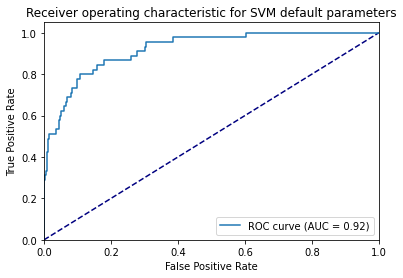

              precision    recall  f1-score  support
0              0.940054  0.971831  0.955679   355.00
1              0.696970  0.511111  0.589744    45.00
accuracy       0.920000  0.920000  0.920000     0.92
macro avg      0.818512  0.741471  0.772711   400.00
weighted avg   0.912707  0.920000  0.914511   400.00


In [48]:
#plot roc for svm
get_roc(clf_original, y_test, norm_test_df, "SVM default parameters")
report = classification_report(y_test, clf_original.predict(norm_test_df), output_dict = True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

In [49]:
y_pred2 = clf_original.predict(norm_test_df)
pd.DataFrame(classification_report(y_test, y_pred2, output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.940054,0.971831,0.955679,355.00
1,0.696970,0.511111,0.589744,45.00
accuracy,0.920000,0.920000,0.920000,0.92
macro avg,0.818512,0.741471,0.772711,400.00
weighted avg,0.912707,0.920000,0.914511,400.00


In [0]:
from sklearn.metrics import precision_recall_curve

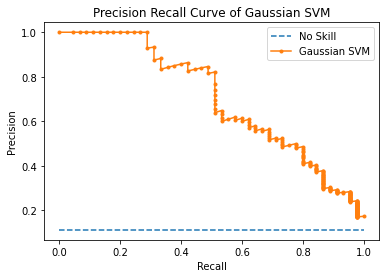

In [51]:
SVM_probs = clf_original.predict_proba(norm_test_df)
SVM_probs = SVM_probs[:, 1] # Keep probability predictions for good quality (=1) class only
precisions, recalls, _ = precision_recall_curve(y_test, SVM_probs)

# Plot PR-Curve
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recalls, precisions, marker='.', label='Gaussian SVM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# annotate optimised model's recall and precision
# Title
plt.title("Precision Recall Curve of Gaussian SVM")
# show the plot
plt.show()

In [52]:
# Cross Validated Score (f1_macro & f1 - Skewed by imbalanced data)
cv_score_f1_macro = cross_val_score(clf_original, norm_train_df, y_train, cv=10, scoring="f1_macro")
print("Cross-Val F1-macro Score: %0.3f" % (np.mean(cv_score_f1_macro))) # 0.696
cv_score_f1 = cross_val_score(clf_original, norm_train_df, y_train, cv=10, scoring="f1")
print("Cross-Val F1 Score: %0.3f" % (np.mean(cv_score_f1))) # 0.46594
cv_score_recall = cross_val_score(clf_original, norm_train_df, y_train, cv=10, scoring="recall")
print("Cross-Val Recall Score: %0.3f" % (np.mean(cv_score_recall))) # 0.4222
cv_score_prec = cross_val_score(clf_original, norm_train_df, y_train, cv=10, scoring="precision")
print("Cross-Val Precision Score: %0.3f" % (np.mean(cv_score_prec)))  # 0.6243

Cross-Val F1-macro Score: 0.732
Cross-Val F1 Score: 0.528
Cross-Val Recall Score: 0.441
Cross-Val Precision Score: 0.676


In [53]:
confusion(y_test,clf_original.predict(norm_test_df), "SVM default parameters")

Of 45 Defaulters, the SVM default parameters identified 23


Predicted,0,1
Actual,,
0,345,10
1,22,23


<h2> Hypothesis Testing </h2>

In [55]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

clf_original = svm.SVC( probability = True,class_weight='balanced', C = c_value, gamma = gamma_value)
clf_original.fit(norm_train_df, y_train)
perm = PermutationImportance(clf_original, random_state=1, n_iter=10, scoring = "f1_macro").fit(norm_test_df, y_test)
eli5.show_weights(perm, feature_names = norm_test_df.columns.tolist()) # See on Jupyter Notebook

     |████████████████████████████████| 112kB 3.4MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


Weight,Feature
0.1910 ± 0.0676,alcohol
0.1576 ± 0.0830,citric acid
0.1481 ± 0.0725,volatile acidity
0.1297 ± 0.0358,density
0.1120 ± 0.0709,pH
0.1094 ± 0.0495,sulphates
0.1056 ± 0.0505,total_acidity
0.1055 ± 0.0762,pH_sulphate
0.1007 ± 0.0573,fixed acidity
0.0968 ± 0.0498,total sulfur dioxide


In [56]:
# Results from Perm Importance ELI5 Feature Selection
X_train_eli5 = norm_train_df.copy()
# Results from Perm Importance ELI5 Feature Selection
X_test_eli5 = norm_test_df.copy()
c_eli5 = svc_rbf_param_selection(X_train_eli5, y_train,5)['C']
gamma_eli5 = svc_rbf_param_selection(X_train_eli5, y_train,5)['gamma']
SVM_eli5 = svm.SVC( probability = True,class_weight='balanced', C = c_eli5, gamma = gamma_eli5)
SVM_eli5.fit(X_train_eli5, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Optimal Threshold: 0.13172965003562548
Gaussian SVM AUROC: 0.92


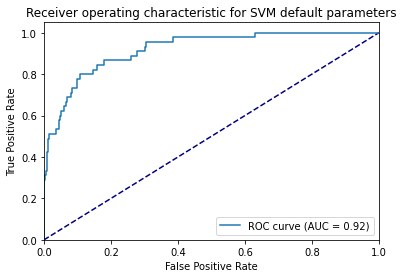

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       355
           1       0.70      0.51      0.59        45

    accuracy                           0.92       400
   macro avg       0.82      0.74      0.77       400
weighted avg       0.91      0.92      0.91       400



In [57]:
#plot roc for svm
get_roc(SVM_eli5, y_test, X_test_eli5, "SVM default parameters")
print(classification_report(y_test, SVM_eli5.predict(X_test_eli5)))

<p>Slight improvement in key metrics after feature selection using permutation importance</p>

In [58]:
# Cross Validated Score (f1_macro & f1 - Skewed by imbalanced data)
cv_score_f1_macro = cross_val_score(SVM_eli5, X_train_eli5, y_train, cv=10, scoring="f1_macro")
print("Cross-Val F1-macro Score: %0.3f" % (np.mean(cv_score_f1_macro))) # 0.696
cv_score_f1 = cross_val_score(SVM_eli5, X_train_eli5, y_train, cv=10, scoring="f1")
print("Cross-Val F1 Score: %0.3f" % (np.mean(cv_score_f1))) # 0.46594
cv_score_recall = cross_val_score(SVM_eli5, X_train_eli5, y_train, cv=10, scoring="recall")
print("Cross-Val Recall Score: %0.3f" % (np.mean(cv_score_recall))) # 0.4222
cv_score_prec = cross_val_score(SVM_eli5, X_train_eli5, y_train, cv=10, scoring="precision")
print("Cross-Val Precision Score: %0.3f" % (np.mean(cv_score_prec)))  # 0.6243

Cross-Val F1-macro Score: 0.732
Cross-Val F1 Score: 0.528
Cross-Val Recall Score: 0.441
Cross-Val Precision Score: 0.676


In [59]:
print("my Confusion Matrix A:\n", my_confusion_matrix(y_test,SVM_eli5.predict(X_test_eli5)))

my Confusion Matrix A:
 [[345 10]
  [22 23]]


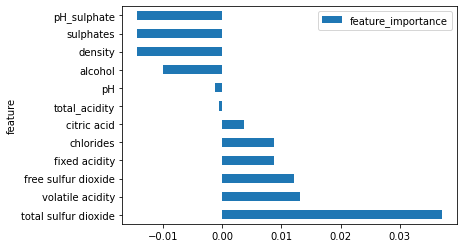

In [60]:
# Drop Column Feature Importance
from sklearn.base import clone

# Helper Function
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
    return df

# Drop Col Feat Importance Function
from sklearn.metrics import f1_score

def drop_col_feat_imp(model, X_train, y_train, X_test, y_test, random_state=42):
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    # y_pred
    y_pred = model_clone.predict(X_test) # *
    benchmark_score = f1_score(y_test, y_pred, average='macro') #model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []

    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis=1), y_train)
        y_pred = model_clone.predict(X_test.drop(col, axis=1)) # *
        drop_col_score = f1_score(y_test, y_pred, average='macro') #model_clone.score(X_train.drop(col, axis=1), y_train)
        importances.append(benchmark_score - drop_col_score)

    importances_df = imp_df(X_train.columns, importances)
    return importances_df

drop_col_results = drop_col_feat_imp(clf_original, norm_train_df, y_train, norm_test_df, y_test)

# Graphing it
drop_col_results.plot.barh(x='feature', y='feature_importance')
plt.show()